In [1]:
import json
import requests
import pandas as pd
import yfinance as yf

url = "https://raw.githubusercontent.com/rreichel3/US-Stock-Symbols/main/nyse/nyse_full_tickers.json"

resp = requests.get(url)
data = json.loads(resp.text)
pd.DataFrame(data)

,symbol,name,lastsale,netchange,pctchange,volume,marketCap,country,ipoyear,industry,sector,url
0,A,Agilent Technologies Inc. Common Stock,$139.45,1.93,1.403%,1097922,40866559354.00,United States,1999,Biotechnology: Laboratory Analytical Instruments,Industrials,/market-activity/stocks/a
1,AA,Alcoa Corporation Common Stock,$36.77,0.83,2.309%,5491834,6602384062.00,United States,2016,Aluminum,Industrials,/market-activity/stocks/aa
2,AACT,Ares Acquisition Corporation II Class A Ordina...,$10.62,-0.01,-0.094%,12213,0.00,,2023,Blank Checks,Finance,/market-activity/stocks/aact
3,AAN,Aarons Holdings Company Inc. Common Stock,$6.95,0.16,2.356%,150957,211011966.00,United States,2020,Diversified Commercial Services,Consumer Discretionary,/market-activity/stocks/aan
4,AAP,Advance Auto Parts Inc.,$76.31,1.39,1.855%,790045,4544340015.00,United States,,Auto & Home Supply Stores,Consumer Discretionary,/market-activity/stocks/aap
...,...,...,...,...,...,...,...,...,...,...,...,...
2802,ZTR,Virtus Total Return Fund Inc.,$5.35,-0.03,-0.558%,356136,0.00,United States,1988,Investment Managers,Finance,/market-activity/stocks/ztr
2803,ZTS,Zoetis Inc. Class A Common Stock,$167.07,-0.16,-0.096%,3006962,76495858903.00,United States,2013,Biotechnology: Pharmaceutical Preparations,Health Care,/market-activity/stocks/zts
2804,ZUO,Zuora Inc. Class A Common Stock,$10.08,0.31,3.173%,1326869,1471680000.00,United States,2018,EDP Services,Technology,/market-activity/stocks/zuo
2805,ZVIA,Zevia PBC Class A Common Stock,$0.9183,0.0183,2.033%,166127,65979887.00,United States,2021,Beverages (Production/Distribution),Consumer Staples,/market-activity/stocks/zvia


In [2]:
yf.Ticker("VTI").info

{'phone': '800-523-1036',
 'longBusinessSummary': 'The fund employs an indexing investment approach designed to track the performance of the index, which represents approximately 100% of the investable U.S. stock market and includes large-, mid-, small-, and micro-cap stocks. It invests by sampling the index, meaning that it holds a broadly diversified collection of securities that, in the aggregate, approximates the full index in terms of key characteristics.',
 'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 253.53,
 'open': 254.8,
 'dayLow': 254.62,
 'dayHigh': 255.8099,
 'regularMarketPreviousClose': 253.53,
 'regularMarketOpen': 254.8,
 'regularMarketDayLow': 254.62,
 'regularMarketDayHigh': 255.8099,
 'trailingPE': 24.044186,
 'volume': 2109046,
 'regularMarketVolume': 2109046,
 'averageVolume': 3110838,
 'averageVolume10days': 2765430,
 'averageDailyVolume10Day': 2765430,
 'bid': 255.56,
 'ask': 255.59,
 'bidSize': 900,
 'askSize': 1800,
 'yield': 0.014199999,
 'totalAssets'

In [3]:
import yfinance as yf

tickers = ["AES", "AESI", "AAPL", "META"]

f = []
for ticker in tickers:
    a = ["symbol", "beta", "revenueGrowth", "priceToBook", "debtToEquity", "profitMargins", "quickRatio", 
         "fiftyDayAverage", "pegRatio"]
    try:
        f.append(dict(filter(lambda item: item[0] in a, yf.Ticker(ticker).info.items())))
    except KeyError:
        continue
    except ValueError:
        continue

f = pd.DataFrame(f)
# f.insert(0,"symbol", tickers)

a = ["symbol", "beta", "revenueGrowth", "priceToBook", "debtToEquity", "profitMargins", "quickRatio", 
         "fiftyDayAverage", "pegRatio"]
f[a]

,symbol,beta,revenueGrowth,priceToBook,debtToEquity,profitMargins,quickRatio,fiftyDayAverage,pegRatio
0,AES,1.087,-0.048,4.629993,391.647,0.04235,0.436,16.6362,1.30
1,AESI,NaN,-0.058,2.610650,20.510,0.26059,3.039,21.7406,-31.57
2,AAPL,1.276,-0.043,37.420883,140.968,0.26306,0.875,172.4082,2.54
3,META,1.184,0.273,7.817065,25.168,0.32063,2.546,491.3752,0.75


In [4]:
a = ["beta", "revenueGrowth", "priceToBook", "debtToEquity", "profitMargins", "quickRatio", 
    "fiftyDayAverage", "pegRatio"]

tick = {"AAPL": dict(filter(lambda item: item[0] in a, yf.Ticker("AAPL").info.items()))}

pd.DataFrame(tick)

,AAPL
beta,1.276000
debtToEquity,140.968000
fiftyDayAverage,172.408200
pegRatio,2.540000
priceToBook,37.418854
profitMargins,0.263060
quickRatio,0.875000
revenueGrowth,-0.043000


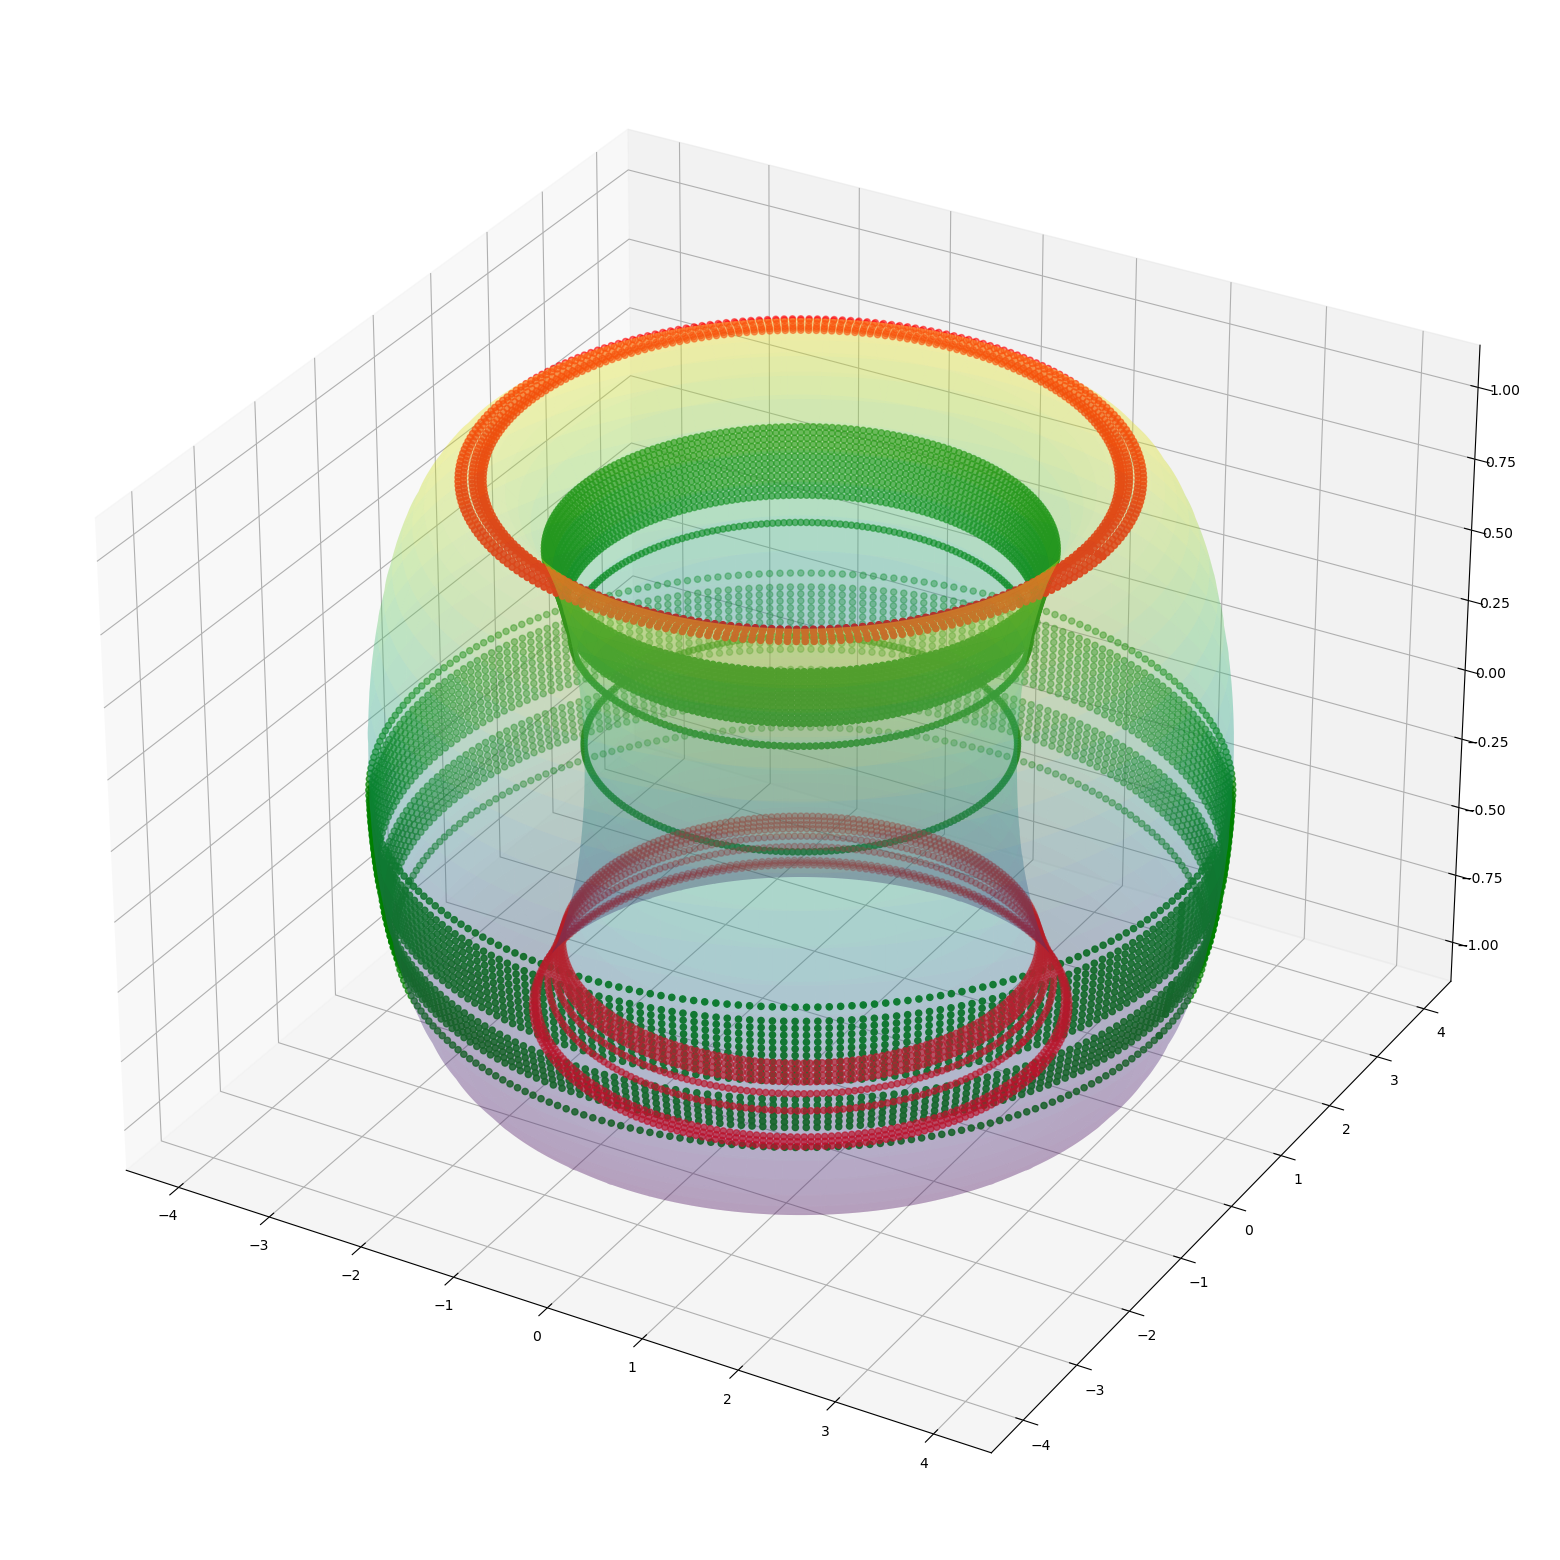

In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate some random price data
# np.random.seed(42)
tick = yf.Ticker("INCY").history(period="1y")
prices = np.array(tick["Open"])

big = 2*np.pi

norm_price = ((prices - np.min(prices)) / (np.max(prices) - np.min(prices))) * big

# Calculate the mean and standard deviation
window = 50
rolling_mean = pd.Series(norm_price).rolling(window=window).mean()
rolling_std = pd.Series(norm_price).rolling(window=window).std()

# Create signals
buy_signal = norm_price < rolling_mean - (2 * rolling_std)
sell_signal = norm_price > rolling_mean + (2 * rolling_std)

# Define parametric equations for a torus
def torus_parametric(u, v, R, r):
    x = (R + r * np.cos(v)) * np.cos(u)
    y = (R + r * np.cos(v)) * np.sin(u)
    z = r * np.sin(v)
    return x, y, z

# Parameters for the torus
R = 3  # Major radius
r = 1  # Minor radius

# Generate torus coordinates
u = np.linspace(0,big,len(prices))
v = np.linspace(0,big,len(prices))
U, V = np.meshgrid(u, v)
X, Y, Z = torus_parametric(U, V, R, r)

# Plot the torus
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, alpha=0.2, cmap='viridis')

# Plot the price data
ax.scatter(X[buy_signal], Y[buy_signal], Z[buy_signal], color='g', label='Buy Signal')
ax.scatter(X[sell_signal], Y[sell_signal], Z[sell_signal], color='r', label='Sell Signal')

plt.show()

In [21]:
buy_signal = pd.DataFrame(buy_signal)
buy_signal["Signal"] = "Buy"

sell_signal = pd.DataFrame(sell_signal)
sell_signal["Signal"] = "Sell"

buy_signal = buy_signal.rename(columns={0:"Action"})
sell_signal = sell_signal.rename(columns={0:"Action"})

actions = pd.concat([buy_signal[buy_signal["Action"] == True],sell_signal[sell_signal["Action"] == True]],axis=0).reset_index()
                     
actions = actions.sort_values(by=["index"],ascending=True).reset_index(drop=True)

actions = actions.drop(["Action"],axis=1)

actions

,index,Signal
0,58,Sell
1,60,Sell
2,63,Sell
3,65,Sell
4,66,Sell
5,67,Sell
6,91,Buy
7,92,Buy
8,93,Buy
9,94,Buy
